This notebook should predict WB_sg from 9 input features.

Andrew Fagerheim and Bernard Wang

In [18]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cwd = os.getcwd()
input_features = ['grad_B','FCOR', 'HML', 'TAU', 'Q', 'HBL', 'div', 'vort', 'strain']
output_feature = 'WB_sg'

# Things about the data we are learning:
- There are 9 input features, 1 output feature. len(input_features) = 9
- it looks like there are 12 locations, each with 846 time ticks.
- len(yo)/846 = 12.0
- so, 0-845 is one location. Then 846-846+845 is another location.
- Seems like there are two roughly two time ticks per day. 2/day makes sense? idk ask
- They are 40 by 40 latitude and longitude boxes, by the way.
- would it be helpful to have the actual latitude and longitudes? or does it not matter? i'm cool with not having em..
  - but, we want to weight our data, no?? without lat, we don't weight our data properly......
- Looks like the data runs from like mid October one year to mid October the next. why? no clue. 
- does the model run on all the locations? or just one location? where does self.loc come in? is it ever set to just one location when the model runs?
- the CNN/NN example notebooks use CO2 and CH4, which only have one value per time tick, rather than one for each lat/lon pair. So, they are 1-D time series rather than 3-D time series. Very interesting.

In [3]:
#yo = np.load('data/Q.npy')
#plt.contourf(yo[846+845, :, :])
#plt.contourf(yo[846*2, :, :])

# We are going to work with just one location (40x40) for now. So, the first 846 indices of the data.
### Eventually gotta figure out how this model works.. with all 12 locations. for now we just use one.

#### Load Input

In [3]:
# load input. (We gonna just look at one location for now, so the first 846 indices)

# 1. Create xarray dataset, populate it with the numpy files but turn them into dataarrays.
X_train_xr = xr.Dataset()
for input_feature in input_features:
    var = np.load('data/%s.npy' % input_feature)[:846]
    var_xr = xr.DataArray(var, coords={'time': np.arange(0, len(var)),'lat': np.arange(0, 40),'lon': np.arange(0, 40)}, dims=["time", "lat", "lon"])
    X_train_xr[input_feature] = var_xr
# X_train_xr is created, which is a Dataset that has all of the input variables time series. It has a lat/lon component though, I hope that is ok?

In [4]:
# 2. Build the dataframe, by going through each input feature and adding its timeseries.
vars = {}
for input_feature in input_features:
    vars[input_feature] = X_train_xr[input_feature].mean(dim=['lat','lon'])
    
X_train_df = pd.DataFrame(vars, index=X_train_xr["grad_B"].coords['time'].data)
X_train_df.head()
# NOTE: we are taking the mean for now, because the input variables still have lat/lon properties. maybe we treat it like the output????

,grad_B,FCOR,HML,TAU,Q,HBL,div,vort,strain
0,1.696983e-08,0.000012,-65.626640,0.066126,-75.480782,41.129562,-2.012549e-08,-5.445170e-07,0.000003
1,1.703827e-08,0.000012,-64.006508,0.062027,-78.757126,40.013718,-8.870204e-09,-5.474857e-07,0.000004
2,1.712170e-08,0.000012,-62.030067,0.056741,-81.845100,37.033009,-1.127527e-09,-5.442436e-07,0.000004
3,1.721165e-08,0.000012,-60.149670,0.051667,-86.461914,35.240181,8.901670e-09,-5.348286e-07,0.000004
4,1.726613e-08,0.000012,-57.631203,0.047175,-88.721039,31.287781,1.145182e-08,-5.256584e-07,0.000004


#### Load Output

In [5]:
# 1. load WB_sg numpy file from data.
WB_sg = np.load('data/WB_sg.npy')[:846]
# 2. turn the data into an xarray dataarray
WB_sg_xr = xr.DataArray(WB_sg, coords={'time': np.arange(0, len(WB_sg)),'lat': np.arange(0, 40),'lon': np.arange(0, 40)}, dims=["time", "lat", "lon"])
y_train = WB_sg_xr.data

# note: need to figure out what the test data should be here... check w the repo.

# FOR NN's btw:
# y_train_df = WB_sg_xr.stack(dim=["lat", "lon"])
# y_train_df = pd.DataFrame(y_train_df.to_pandas())
# y_train_df.head()

In [6]:
# Data normalization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df_norm   = (X_train_df - mean)/std
#X_test_df    = (X_test_df - mean)/std

X_train = X_train_df_norm.to_numpy()
#X_test = X_test_df.to_numpy()

print(X_train.shape,y_train.shape)
#print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(846, 9) (846, 40, 40)


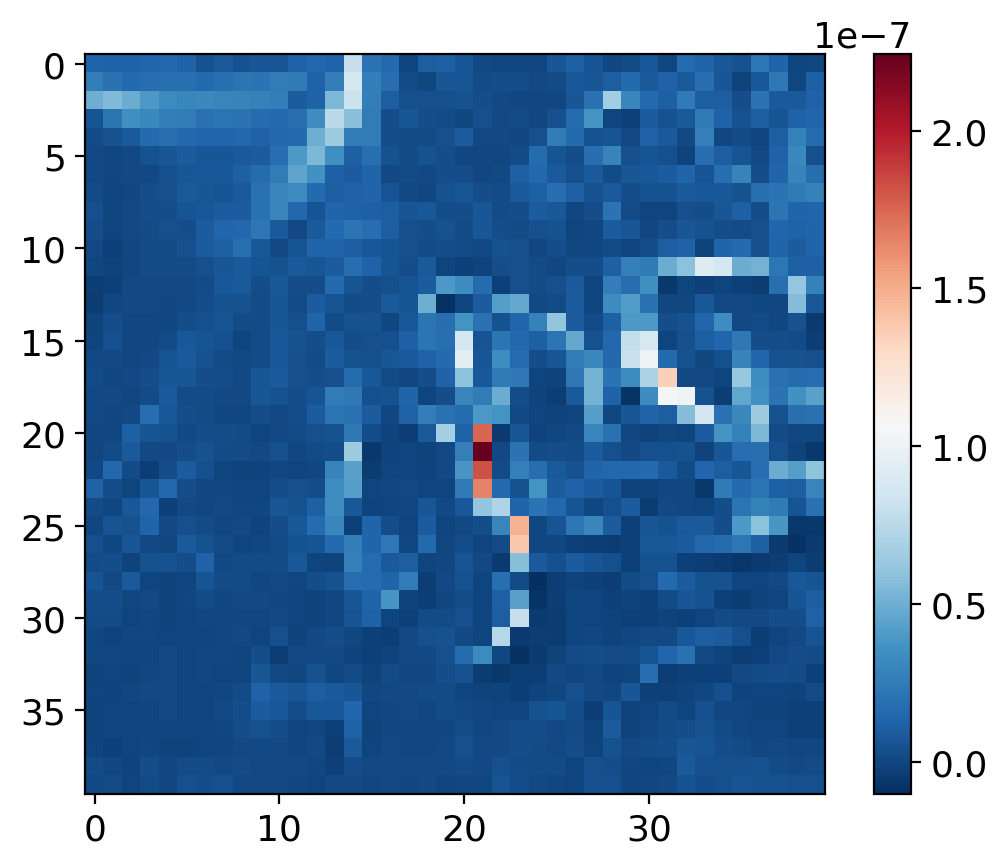

In [9]:
plt.imshow(np.flip(y_train[0],axis=0),cmap='RdBu_r')
plt.colorbar()

## Define CNN Structure

In [10]:
n_filters  = 32  # number of filters
n_neurons  = 32  # number of neurons in the Dense layer
activation     = 'relu' # activation function
kernel_size    = 4
learning_rate  = 0.001
minibatch_size = 64
num_epochs     = 100

In [11]:
### model using MSE as loss function
model_mse = Sequential()

model_mse.add(Dense(n_filters*12*18, input_shape=(X_train.shape[1],), activation=activation)) # shape: (6912,1)

In [12]:
### model using MSE as loss function
model_mse = Sequential()

model_mse.add(Dense(n_filters*5*5, input_shape=(X_train.shape[1],), activation=activation)) # shape: (6912,1)
model_mse.add(Reshape((5,5,n_filters))) # shape: (5,5,32)

# Upsample to 10x10
model_mse.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (10,10,32)

# Upsample to 20x20
model_mse.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (20,20,32)

# Upsample to 40x40
model_mse.add(Conv2DTranspose(filters=n_filters, kernel_size=kernel_size, 
                          activation=activation, strides=2, padding='same')) # shape: (40,40,32)

model_mse.add(Conv2DTranspose(filters=1, kernel_size=kernel_size, activation="linear", padding="same")) # shape: (96,144,1)


model_mse.summary()
model_mse.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 800)               8000      
                                                                 
 reshape (Reshape)           (None, 5, 5, 32)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 10, 10, 32)       16416     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 20, 20, 32)       16416     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 40, 40, 32)       16416     
 ranspose)                                                       
                                                      

## Train da model

In [13]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

###------------mse------------
history_mse = model_mse.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])

Epoch 1/100
11/11 [==============================] - 3s 201ms/step - loss: 1.2720e-05 - val_loss: 4.2162e-07
Epoch 2/100
11/11 [==============================] - 2s 213ms/step - loss: 3.6276e-07 - val_loss: 1.1722e-08
Epoch 3/100
11/11 [==============================] - 2s 162ms/step - loss: 6.8057e-08 - val_loss: 2.1158e-09
Epoch 4/100
11/11 [==============================] - 2s 161ms/step - loss: 2.2178e-08 - val_loss: 3.6167e-09
Epoch 5/100
11/11 [==============================] - 2s 170ms/step - loss: 8.9350e-09 - val_loss: 4.5822e-09
Epoch 6/100
11/11 [==============================] - 2s 170ms/step - loss: 4.3604e-09 - val_loss: 2.9165e-09
Epoch 7/100
11/11 [==============================] - 2s 161ms/step - loss: 2.4514e-09 - val_loss: 7.7924e-10
Epoch 8/100
11/11 [==============================] - 2s 169ms/step - loss: 1.6722e-09 - val_loss: 4.7727e-10
Epoch 9/100
11/11 [==============================] - 2s 162ms/step - loss: 1.4745e-09 - val_loss: 5.1769e-10
Epoch 10/100
11/11 

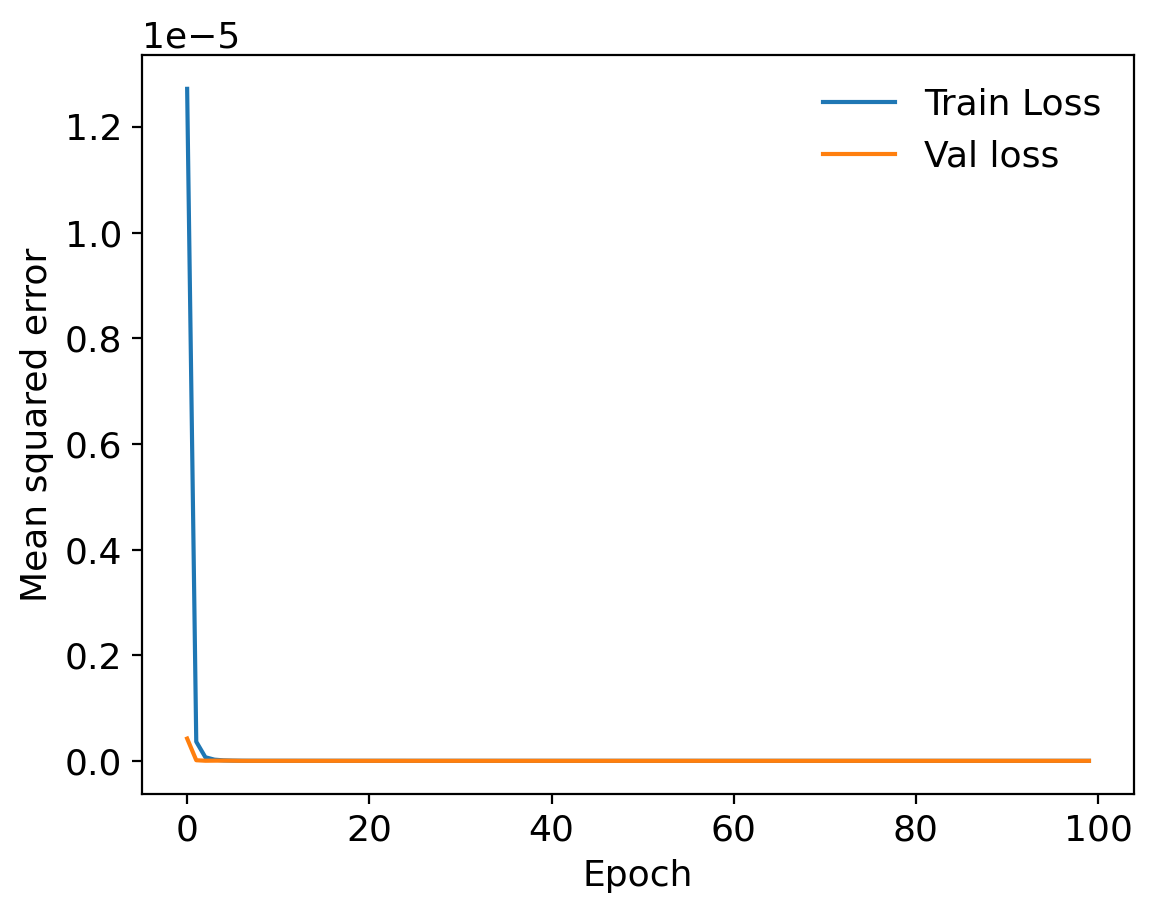

In [14]:
plot_history(history_mse)

In [17]:
model_path = os.path.join(cwd,'model')
make_dir(model_path)

In [18]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model_mse.save(os.path.join(model_path,'CNN_model_mse.h5'))

In [19]:
# reload the saved model
model_mse = load_model(os.path.join(model_path,'CNN_model_mse.h5'))

In [ ]:
# do sum predictions or sumn later

In [14]:
in_features=[]
for input_feature in input_features:
    in_features.append(np.load('data/%s.npy' % input_feature))
bro = np.stack(in_features,axis=1)

In [15]:
bro.shape

(10152, 9, 40, 40)

In [41]:
# Emulating what abigail has done with splitting training and testing

# takes all of the time tick indices, shuffles them randomly.
time_ind = bro.shape[0]
rand_ind = np.arange(time_ind)
rand_seed = 123
random.Random(rand_seed).shuffle(rand_ind)
# rand_ind is [0, 846 or whatever is the time tick length] but shuffled.

# take 80% for training, 20% for testing
train_split = 0.8
train_ind, test_ind = rand_ind[:round(train_split*time_ind)], rand_ind[round((train_split)*time_ind):]
print("Amount of indices in training data: ", train_ind.shape)
print("Amount of indices in testing data: ", test_ind.shape)

# sort back into order
sorted_train_ind = np.sort(train_ind)


# So, what we're seeing is she's just taking 80% of the dataset to use as training data.
# Take 80% totally randomly. 80% of the time ticks are set as training.
# 20% of the time ticks are set to be testing.
# Every one of the 9 input variables, and the 1 output variable share the same time series ticks.
# so it's gonna be 80% of the input and output = train, and 20% of the input and output = test.

Amount of indices in training data:  (8122,)
Amount of indices in testing data:  (2030,)
